In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
%matplotlib inline

In [96]:
weather = pd.read_table('daily_weather.tsv')
usage = pd.read_table('usage_2012.tsv')
stations = pd.read_table('stations.tsv')

1. To start with, we'll need to compute the number of rentals per station per day. Use pandas to do that.

In [97]:
station_counts = usage.groupby('station_start')['station_start'].count()
station_rentals_per_day = DataFrame()
station_rentals_per_day['rentals'] = station_counts.values / 366.0
station_rentals_per_day['station'] = station_counts.index


In [98]:
station_rentals_per_day.head()


,rentals,station
0,17.289617,10th & E St NW
1,10.418033,10th & Monroe St NE
2,71.243169,10th & U St NW
3,55.773224,10th St & Constitution Ave NW
4,35.185792,11th & H St NE


2. a. Our stations data has a huge number of quantitative attributes: fast_food, parking, restaurant, etc... Some of them are encoded as 0 or 1 (for absence or presence), others represent counts. To start with, run a simple linear regression where the input (x) variables are all the various station attributes and the output (y) variable is the average number of rentals per day.

In [99]:
s = stations[['station']]
u = pd.concat([usage['station_start']], axis=1, keys=['station'])
counts = u['station'].value_counts()
c = DataFrame(counts.index, columns=['station'])
c['counts'] = counts.values
c['counts'] = c['counts'].apply(lambda x: x / 366)
m = pd.merge(s, c, on='station')
stations_data = stations.merge(m, on='station')

In [100]:
df = DataFrame(stations_data.index, columns=['station'])
df['avg_rentals'] = m[['counts']]
df['station'] = m[['station']]
stations_vals = pd.merge(left=df, right=stations, on='station')

In [101]:
x = stations_vals[list(stations_vals.columns.values[8:])]
y = stations_vals[list(stations_vals.columns.values[1:2])]
linear_regression = linear_model.LinearRegression()
linear_regression.fit(x, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

2. b. Plot the predicted values (model.predict(x)) against the actual values and see how they compare.

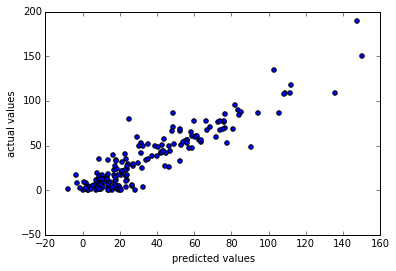

In [102]:
plt.scatter(linear_regression.predict(x), y)
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

2. c. In this case, there are 129 input variables and only 185 rows which means we're very likely to overfit. Look at the model coefficients and see if anything jumps out as odd.

In [103]:
linear_regression.coef_

array([[  2.33163477e+00,  -2.58798372e-01,   7.38677614e-02,
         -6.23427298e+01,   2.02686671e+00,  -4.16148234e+00,
          5.55342631e+00,   1.78810014e+00,  -3.64436832e-01,
          1.46056713e-12,   2.38199452e+00,   6.88744836e+01,
          4.53635614e+00,  -1.04894937e-11,  -2.95916174e-12,
          5.24210306e+00,  -6.00994500e-12,   4.39207876e+00,
          9.26717502e+00,  -3.03514381e+00,   3.19641175e+00,
         -3.75470868e+01,   2.78908576e+01,  -3.85399854e+01,
         -1.58860736e+01,   2.17147435e+01,   1.50931200e+00,
          3.01466161e+00,  -4.32875603e+00,   8.85951246e+00,
          2.17147435e+01,  -2.71793215e-01,   3.44540930e+00,
          1.28336434e+01,   4.84020690e+00,  -2.04169817e+00,
         -3.45267737e+01,  -1.61959403e+01,   5.26641596e+00,
          5.16406843e+00,   1.13106239e+01,  -5.95501207e+00,
          1.47321423e+02,  -5.49234411e+00,  -1.29090263e+01,
          1.82647435e+02,  -9.14848559e-02,   3.95779169e-01,
        

Outlier coeeficents would be inacurate at predicting.

2. d. Go back and split the data into a training set and a test set. Train the model on the training set and evaluate it on the test set. How does it do?

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
lin_regr = linear_model.LinearRegression()
lin_regr.fit(x_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

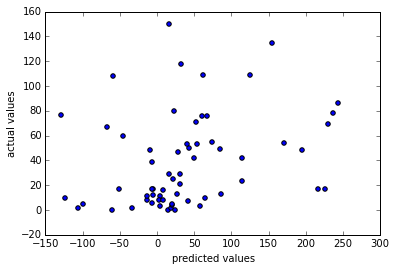

In [105]:
plt.scatter(lin_regr.predict(x_test), y_test)
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

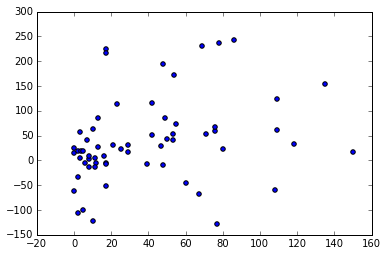

In [106]:
plt.scatter(y_test, lin_regr.predict(x_test) )

Too many outliers. Would be innacurate.

3. a. Since we have so many variables, this is a good candidate for regularization. In particular, since we'd like to eliminate a lot of them, lasso seems like a good candidate. Build a lasso model on your training data for various values of alpha. Which variables survive?

In [107]:
model = Lasso(alpha=.1)
model.fit(x_train, y_train)
np.round(model.coef_, 1)

array([  2.5,  -1.7,   0.5,   0. ,  -3.8,  -0.2,   8. ,   0. ,  -0.1,
         0. ,  -0.6,   0. ,  -1.1,   0. ,   0. ,   0. ,   0. ,  -4.9,
         0. ,  -0.1,  -0.1,   6.9,   5.1, -10.6,  -0. ,  -0. ,  -3.1,
         3.3,   7.2,   0.5,  -0. ,  -0. ,   1.7,   7.2,   3.5,   0. ,
        -0. , -10.7,  -0. ,  -0. ,  -6.9,   3.4,  66.1,   2.1,  -5. ,
        27.6,   6.6,  -1.1,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,
         1.7,   7.2,  23.1,   0. ,   0. ,   0. ,   1.1,   0. ,   0.5,
         0. ,  -1.3,   0. ,   0. ,   1.1,   0. ,  -0. ,   0. ,  -0. ,
       -13. ,   0. ,  -4.9,  -0.7,  -0. ,  -0. ,  -0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,  -0. ,  -0. ,  -0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,  -0.2,   0.4,  -1.9,  -0. ,  18.7,   0. ,
        -1.1,  -3.5,   0. ,   2. , -10.2,  -0. ,   0. ,   0. ,  12.8,
        -0.8,  -0. ,  -1.1,   0. ,   0. ,   2.1,   0. ,  -0. ,  -2.1,
        -0. ,  -0. ,

In [108]:
model = Lasso(alpha=.5)
model.fit(x_train, y_train)
np.round(model.coef_, 1)

array([  1.3,  -1. ,   0.8,   0. ,  -1.7,  -0.7,   9. ,   8.9,  -0.1,
         0. ,   0. ,   0. ,  -0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,
         0. ,  -0.7,  -0. ,   0. ,   0. ,  -0. ,  -0. ,  -0. ,  -5.2,
         2.6,   8.7,   0. ,  -0. ,  -0. ,   0. ,   0. ,   2.4,   0. ,
         0. ,  -7. ,  -0. ,  -0. ,  -0. ,   0. ,   0. ,   0. ,  -0. ,
         0. ,   0. ,  -0. ,  -0. ,  -0. ,   0. ,  -0. ,  -0. ,   0. ,
         0. ,   0. ,   8.2,   0. ,   0. ,   0. ,   0. ,  -0. ,  -0. ,
         0. ,  -0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,   0. ,  -0. ,
        -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,  -0. ,  -0. ,  -0. ,  -0. ,   0. ,   0. ,
        -0. ,   0. ,  -0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,  -0.1,   0.4,  -0. ,   0. ,   0. ,   0. ,
        -1.1,  -1.8,   0. ,   0. ,  -0. ,  -0. ,  -0. ,   0. ,  13.1,
        -0.1,   0. ,  -0. ,   0. ,   0. ,   0. ,   0. ,  -0. ,  -0. ,
        -0. ,  -0. ,

3. b. How does this model perform on the test set?

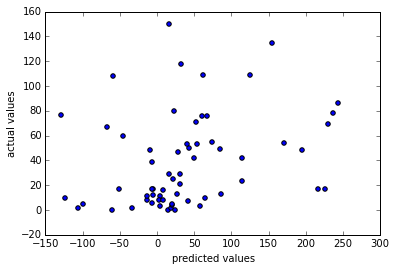

In [109]:
plt.scatter(lin_regr.predict(x_test), y_test)
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

Better.

4. No matter how high I make alpha, the coefficient on crossing ("number of nearby crosswalks") never goes away. Try a simple linear regression on just that variable.

In [110]:
x = stations_vals[list(stations_vals.columns.values[111:112])]
y = stations_vals[list(stations_vals.columns.values[1:2])]
lin_regr = linear_model.LinearRegression()
lin_regr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

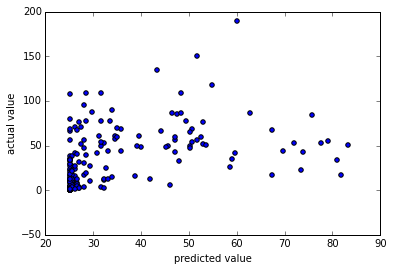

In [115]:
plt.scatter(lin_regr.predict(x), y)
plt.xlabel('predicted value')
plt.ylabel('actual value')
plt.show()